Code to view the pulses kept alongside those cut away.

In [76]:
import sys
import time
import matplotlib.pyplot as plt # https://matplotlib.org/
import numpy as np # http://www.numpy.org/
import tekwfm
import os
from os.path import exists
from scipy import signal
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.special import gamma
import matplotlib.cm as cm
from collections import Counter

import gc
import re
import tempfile
from collections import defaultdict, namedtuple
from pathlib import Path
import pandas as pd

doVerbose = False

In [77]:
#import the wfm file
filename_wfm = "PMT4_WFM_DR/220126_darkrate_1850_10000_3_off"
#import the cleaned file and make data frame
clean_csv = pd.read_csv("PMT4_CLEAN_11SIG_DR/220126_darkrate_1850_10000_3_off_processed_threshold11_cleaned.csv")
#import the processed file
processed_csv = pd.read_csv("PMT4_11SIGMA_PROC_DR/220126_darkrate_1850_10000_3_off_processed_threshold11.csv")
#choose number of events to be seen and starting event (first event is event 0)

startEvent = 9800
nEvents = 100
n = 11     #threshold for pulse to pass
BASELINE_SIGMA_CUT = 15     #currently baseline cutting on mu + 15sigma


volts, tstart, tscale, tfrac, tdatefrac, tdate = tekwfm.read_wfm(filename_wfm+".wfm")
if doVerbose:
    print('>>>>', volts, tstart, tscale, tfrac, tdatefrac, tdate)

samples = volts.shape

print(len(volts))
print(tscale)
print('samples', samples[0])
tstop = samples[0]*tscale+tstart
sampleTimes = [tstart+x*tscale for x in range(samples[0])]
negVolts = [volts[:, event] for event in range(startEvent, startEvent + nEvents)] # all events, array of array of voltages
tempVolts = -volts


"""variables which can be changed"""
baseline_end_frac = 0.15
amplitude_start_frac = 0
amplitude_end_frac = 0.6
pulse_end_frac = 0.99


1250
8e-11
samples 1250


μ_baseline_SD  = 3.587 mV
σ_baseline_SD  = 0.653 mV
Baseline cut (μ + 15σ) = 13.376 mV


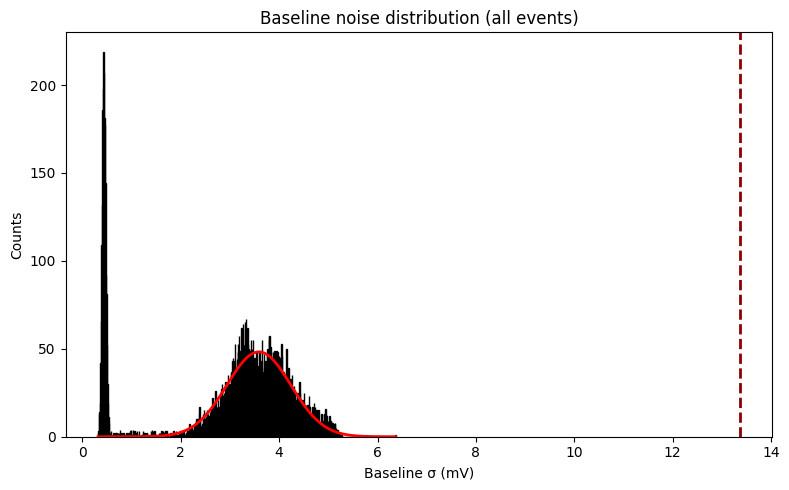

In [78]:
sigma_b_array_mV = processed_csv["sd_baseline"].to_numpy() * 1e3

def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

bins = int((sigma_b_array_mV.max() - sigma_b_array_mV.min()) / 0.01)
counts, edges = np.histogram(sigma_b_array_mV, bins=bins)
centers = 0.5 * (edges[1:] + edges[:-1])

p0 = [counts.max(), centers.mean(), centers.std()]
popt, pcov = curve_fit(gaussian, centers, counts, p0=p0)

mu_sb, sigma_sb = popt[1], popt[2]
BASELINE_CUT_MV = mu_sb + BASELINE_SIGMA_CUT * sigma_sb

print(f"μ_baseline_SD  = {mu_sb:.3f} mV")
print(f"σ_baseline_SD  = {sigma_sb:.3f} mV")
print(f"Baseline cut (μ + 15σ) = {BASELINE_CUT_MV:.3f} mV")


# Plot distribution
plt.figure(figsize=(8,5))
plt.hist(sigma_b_array_mV, bins=bins, color="skyblue", edgecolor="black")
plt.plot(centers, gaussian(centers, *popt), "r", lw=2)
plt.axvline(BASELINE_CUT_MV, color="darkred", ls="--", lw=2)
plt.xlabel("Baseline σ (mV)")
plt.ylabel("Counts")
plt.title("Baseline noise distribution (all events)")
plt.tight_layout()
plt.show()

In [79]:

def calcbaseline(tempVolt):
    baseline = tempVolt[:int(baseline_end_frac * samples[0])]
    mean_b = baseline.mean()
    sigma_b = baseline.std(ddof=1)
    corrected = tempVolt - mean_b
    return mean_b, sigma_b, corrected



def calcamplitude(corrected, samples, sigma_b, sampleTimes):
    min_height = max(5 * sigma_b, 0.003)
    peaks, _ = find_peaks(corrected, height=min_height)
    if len(peaks) > 0:
        peak_idx = peaks[0]
    else:
        peak_idx = np.argmax(corrected)
        peaks = [peak_idx]
    amplitude = corrected[peak_idx]
    return amplitude, peak_idx, peaks



def calc_time_above_3sigma(corrected, times, sigma_b, mean_b, peak_idx):
    threshold = mean_b + 3 * sigma_b
    i = peak_idx
    while i > 0 and corrected[i] > threshold:
        i -= 1
    if i == 0:
        return None
    return times[i]


def integrate_pulse(corrected, start_idx):
    end = int(pulse_end_frac * samples)
    return integrate.trapezoid(corrected[start_idx:end],
                               x=sampleTimes[start_idx:end])


In [80]:
passed_events = set(clean_csv["event_id"].astype(int))
bad_events = []
good_events = []



for event in range(startEvent, startEvent + nEvents):
    if event in passed_events:
        good_events.append(event)
    else:
        bad_events.append(event)

print("Bad events:", bad_events)
print("Good events:", good_events)




def get_rejection_reason(event):
    row = processed_csv[processed_csv["event_id"] == event]
    if row.empty:
        return "event not found", None

    sigma_b_mv = row.iloc[0]["sd_baseline"] * 1e3

    if sigma_b_mv > BASELINE_CUT_MV:
        return "baseline cut", sigma_b_mv

    if row.iloc[0]["time_above_threshold"] <= 0:
        return "time_above_threshold <= 0", sigma_b_mv

    return "other cut", sigma_b_mv

Bad events: [9808, 9813, 9827, 9897]
Good events: [9800, 9801, 9802, 9803, 9804, 9805, 9806, 9807, 9809, 9810, 9811, 9812, 9814, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9825, 9826, 9828, 9829, 9830, 9831, 9832, 9833, 9834, 9835, 9836, 9837, 9838, 9839, 9840, 9841, 9842, 9843, 9844, 9845, 9846, 9847, 9848, 9849, 9850, 9851, 9852, 9853, 9854, 9855, 9856, 9857, 9858, 9859, 9860, 9861, 9862, 9863, 9864, 9865, 9866, 9867, 9868, 9869, 9870, 9871, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9879, 9880, 9881, 9882, 9883, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9895, 9896, 9898, 9899]


In [81]:
def annotate_pulse(ax, sampleTimes, corrected,
                   mean_b, sigma_b,
                   peak_idx, amplitude,
                   first_3sigma_cross,
                   peaks):

    times = np.array(sampleTimes)
    times_ns = times * 1e9
    volts_mv = corrected * 1e3

    ax.axhline(3*sigma_b*1e3, color='red', linestyle=':', label='3σ')
    ax.axhline(1*sigma_b*1e3, color='orange', linestyle='--', label='Baseline s.d.')
    ax.axhline(n*sigma_b*1e3, color='blue', linestyle='--', label=f'{n}σ')
    ax.axvline(times_ns[peak_idx], color='green', linestyle=':', label='Peak')
    ax.axhline(amplitude*1e3, color='green', linestyle=':', label='Peak amplitude')

    #for p in peaks:
        #ax.axvline(times_ns[p], color='green', linestyle=':', alpha=0.5)

    if first_3sigma_cross is not None:
        ax.axvline(first_3sigma_cross*1e9,
                   color='red',
                   linestyle=':',
                   label='3σ crossing')

    x_start = times_ns[0]
    x_end = times_ns[int(0.15 * len(times))]

    ax.axvspan(
        x_start,
        x_end,
        color='blue',
        alpha=0.05,
        label='Baseline region'
    )

    if first_3sigma_cross is not None:
        start_idx = np.searchsorted(times, first_3sigma_cross)
    else:
        start_idx = peak_idx

    end_idx = int(pulse_end_frac * len(times))

    ax.fill_between(
        times_ns[start_idx:end_idx],
        volts_mv[start_idx:end_idx],
        0.0,
        color='magenta',
        alpha=0.2,
        label='Integration region'
    )

    ax.set_xlim(-20, 80)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),
              fontsize=8, loc='upper right')


In [82]:
n_bad = len(bad_events)
n_good = len(good_events)
n_rows = max(n_bad, n_good)

fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, 6*n_rows))

# Fix shape if only one row
if n_rows == 1:
    axes = np.array([axes])


# bad events
for i, event in enumerate(bad_events):

    tempVolt = tempVolts[:, event]
    ax = axes[i, 0]


    mean_b, sigma_b, corrected = calcbaseline(tempVolt)

    amplitude, peak_idx, peaks = calcamplitude(
    corrected, samples, sigma_b, sampleTimes
)

    first_3sig = calc_time_above_3sigma(
        corrected, sampleTimes, sigma_b, mean_b, peak_idx
    )


    ax.plot(
        np.array(sampleTimes) * 1e9,
        corrected * 1e3,
        color='black'
    )


    annotate_pulse(
        ax,
        sampleTimes,
        corrected,
        mean_b,
        sigma_b,
        peak_idx,
        amplitude,
        first_3sig,
        peaks
    )

    reason, sigma_b_mv = get_rejection_reason(event)

    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlabel('Oscilloscope Timebase (ns)', fontsize=14)
    ax.set_xlim(-20, 80)
    ax.set_ylabel('Voltage (mV)', fontsize=14)
    ax.set_ylim(-2, 25)
    
    ax.set_title(f"Event {event} — FAILED", fontsize=12)
    ax.text(
    0.5, -0.28,
    f"Rejected reason: {reason}\n"
    f"Baseline σ = {sigma_b_mv:.2f} mV\n"
    f"Baseline cut = {BASELINE_CUT_MV:.2f} mV",
    transform=ax.transAxes,
    ha='center',
    va='top',
    fontsize=11,
    color='darkred',
    wrap=True
)

    del tempVolt




# good events
for i, event in enumerate(good_events):

    tempVolt = tempVolts[:, event]
    ax = axes[i, 1]


    mean_b, sigma_b, corrected = calcbaseline(tempVolt)
    amp, peak_idx, peaks = calcamplitude(
    corrected, samples, sigma_b, sampleTimes
)
    first_3sig = calc_time_above_3sigma(corrected, sampleTimes, sigma_b, mean_b, peak_idx)

    ax.plot(
        np.array(sampleTimes) * 1e9,
        corrected * 1e3,
        color='black'
    )

    annotate_pulse(
        ax,
        sampleTimes,
        corrected,
        mean_b,
        sigma_b,
        peak_idx,
        amplitude,
        first_3sig,
        peaks
    )

    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlabel('Oscilloscope Timebase (ns)', fontsize=14)
    ax.set_xlim(-20, 80)
    ax.set_ylabel('Voltage (mV)', fontsize=14)
    ax.set_ylim(-2, 25)

    ax.set_title(f"Event {event} — PASSED", fontsize=12)

    del tempVolt



for i in range(n_rows):
    if i >= n_bad:
        axes[i, 0].axis('off')
    if i >= n_good:
        axes[i, 1].axis('off')


fig.text(0.25, 0.985, "BAD pulses (Failed the cuts)", ha='center', va='top',
         fontsize=16, color='red')

fig.text(0.75, 0.985, "GOOD pulses (Passed the cuts)", ha='center', va='top',
         fontsize=16, color='green')

plt.subplots_adjust(top=0.94, hspace=0.6)
plt.show()